In [1]:
import numpy as np
import math
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.stats import shapiro 
from scipy.stats import lognorm
from scipy.stats import kstest,norm
from scipy.stats import lognorm
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = Path.cwd().parent.parent
filePath = str(path) + "/data_cleanup/second_dataset/train_data_price_corrected.parquet"
df = pd.read_parquet(filePath)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10305 entries, 0 to 31633
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   reservation_id           10305 non-null  int64         
 1   stay_date                10305 non-null  datetime64[ns]
 2   guest_id                 10305 non-null  int64         
 3   guest_country_id         10305 non-null  object        
 4   reservation_status       10305 non-null  object        
 5   reservation_date         10305 non-null  datetime64[ns]
 6   date_from                10305 non-null  datetime64[ns]
 7   date_to                  10305 non-null  datetime64[ns]
 8   cancel_date              0 non-null      object        
 9   room_cnt                 10305 non-null  int64         
 10  adult_cnt                10305 non-null  int64         
 11  children_cnt             10305 non-null  int64         
 12  price                    10305 non-nu

In [3]:
room_occupancy = df[(df["cancel_date"].isna())]

dates = []
for index, row in room_occupancy.iterrows():
    delta = (row["date_to"] - row["date_from"]).days
    for i in range(delta):
        dates.append((row["date_from"] + pd.Timedelta(days=i), row["room_cnt"]))

# Pretvaranje u DataFrame
room_dates_df = pd.DataFrame(dates, columns=["date", "room_cnt"])

# Grupiranje po datumu i sumiranje broja gostiju
room_occupancy = room_dates_df.groupby("date")["room_cnt"].sum().reset_index()
room_occupancy.index = room_occupancy["date"]
del room_occupancy["date"]
#room_occupancy.head()

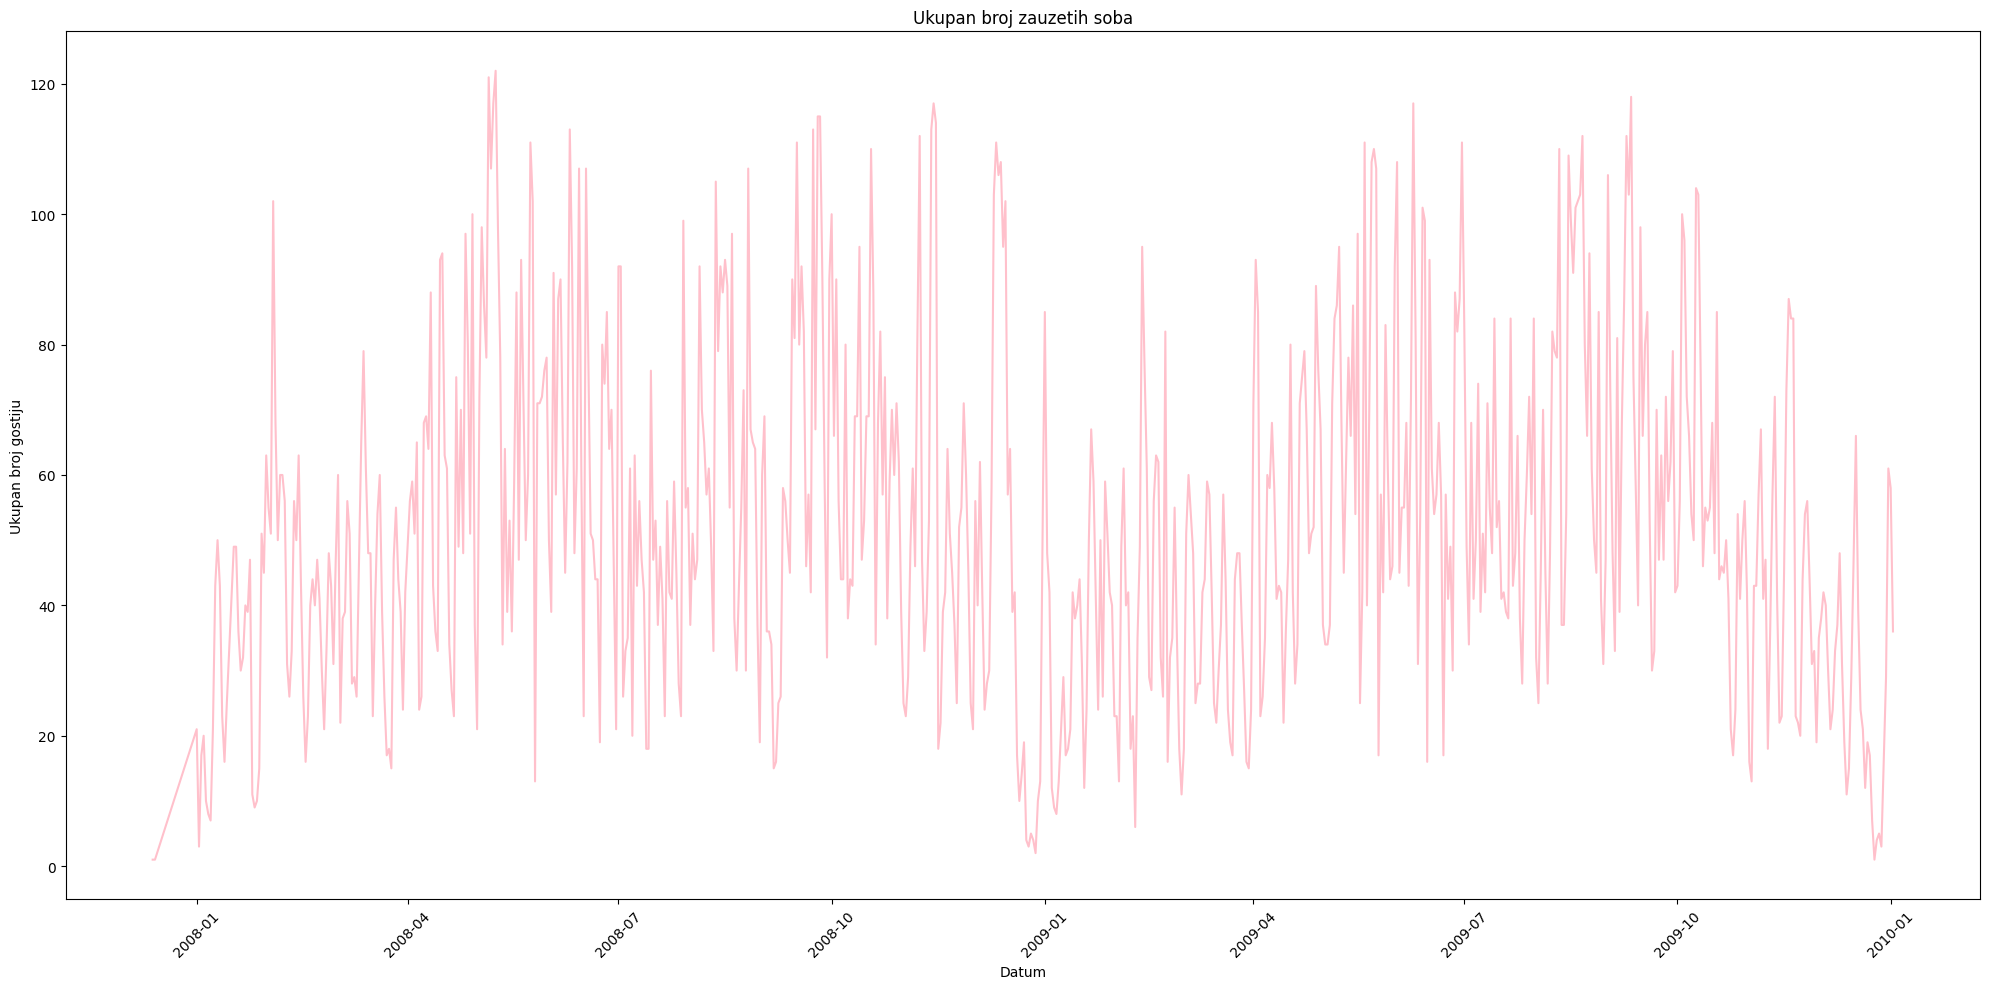

In [4]:
plt.figure(figsize=(20, 10))  
plt.plot(room_occupancy.index, room_occupancy["room_cnt"], color="pink")
plt.title("Ukupan broj zauzetih soba")
plt.xlabel("Datum")
plt.ylabel("Ukupan broj gostiju")
plt.xticks(rotation = 45) 
plt.tight_layout()  
plt.show()

In [5]:
result = adfuller(room_occupancy)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -2.7889165132644993
p-value: 0.05987448951525103
Critical Values:
	1%: -3.4395418285955563
	5%: -2.865596454500293
	10%: -2.5689301318958955


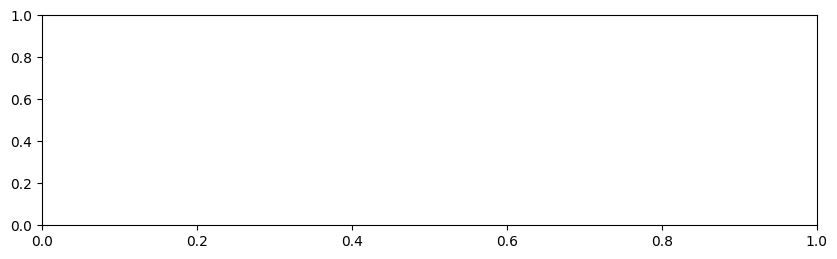

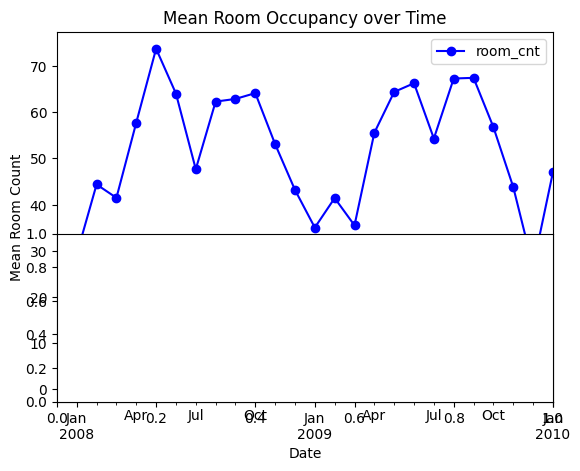

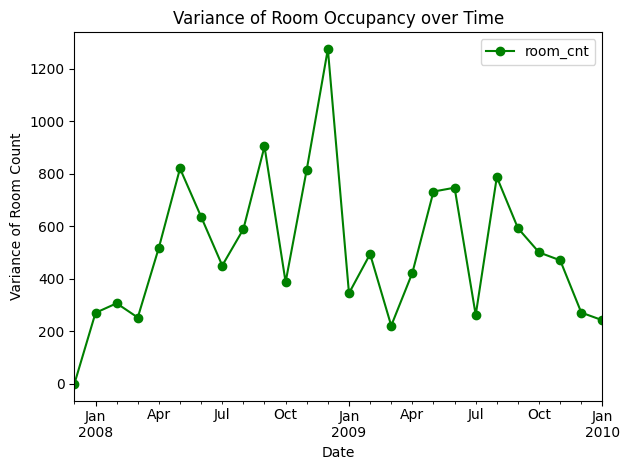

In [6]:
mean_values = room_occupancy.resample('M').mean()
variance_values = room_occupancy.resample('M').var()

plt.figure(figsize=(10, 6))


plt.subplot(2, 1, 1)
mean_values.plot(marker='o', color='blue')
plt.title('Mean Room Occupancy over Time')
plt.xlabel('Date')
plt.ylabel('Mean Room Count')

plt.subplot(2, 1, 2)
variance_values.plot(marker='o', color='green')
plt.title('Variance of Room Occupancy over Time')
plt.xlabel('Date')
plt.ylabel('Variance of Room Count')

plt.tight_layout()
plt.show()

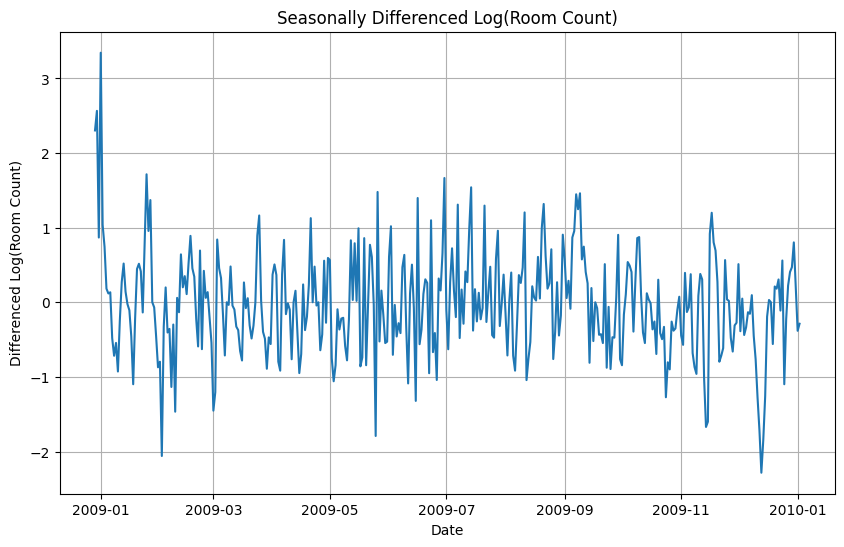

In [29]:

# Apply logarithm function to guest_count data
room_occupancy["room_count_log"] = np.log(room_occupancy["room_cnt"])

# Seasonal differencing
seasonal_difference = room_occupancy['room_count_log'].diff(periods=365)

# Remove NaN values resulted from differencing
seasonal_difference = seasonal_difference.dropna()

# Plot seasonal differenced data
plt.figure(figsize=(10, 6))
plt.plot(seasonal_difference)
plt.title('Seasonally Differenced Log(Room Count)')
plt.xlabel('Date')
plt.ylabel('Differenced Log(Room Count)')
plt.grid(True)
plt.show()


In [30]:
seasonal_difference_df = seasonal_difference.to_frame(name='room_cnt').reset_index()
seasonal_difference_df.columns = ['date', 'room_cnt']  
seasonal_difference_df = seasonal_difference_df[seasonal_difference_df["date"] > "2009-01-01"]
seasonal_difference_df.head()

,date,room_cnt
4,2009-01-02,1.037988
5,2009-01-03,0.741937
6,2009-01-04,0.182322
7,2009-01-05,0.117783
8,2009-01-06,0.133531


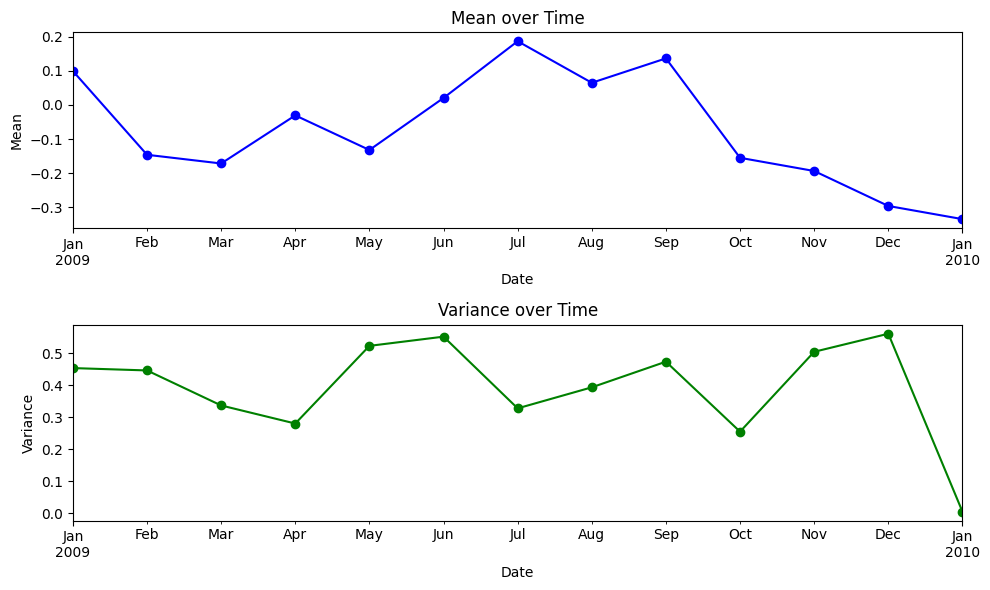

In [31]:
mean_values = seasonal_difference_df.groupby(pd.Grouper(key="date", freq="M"))["room_cnt"].mean()
variance_values = seasonal_difference_df.groupby(pd.Grouper(key="date", freq="M"))["room_cnt"].var()

# Plotting
plt.figure(figsize=(10, 6))

# Plot mean
plt.subplot(2, 1, 1)
mean_values.plot(marker="o", color="blue")
plt.title("Mean over Time")
plt.xlabel("Date")
plt.ylabel("Mean")

# Plot variance
plt.subplot(2, 1, 2)
variance_values.plot(marker="o", color="green")
plt.title("Variance over Time")
plt.xlabel("Date")
plt.ylabel("Variance")

plt.tight_layout()
plt.show()

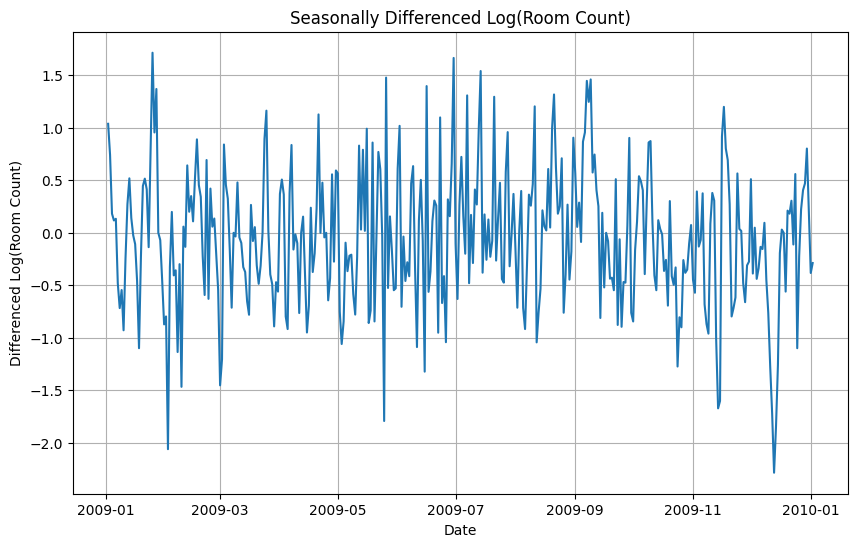

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(seasonal_difference_df["date"], seasonal_difference_df["room_cnt"])
plt.title('Seasonally Differenced Log(Room Count)')
plt.xlabel('Date')
plt.ylabel('Differenced Log(Room Count)')
plt.grid(True)
plt.show()

In [33]:
test = room_occupancy.iloc[2:368]
train = room_occupancy.iloc[368:-1]
print(test.shape, train.shape)

(366, 2) (366, 2)


Text(0.5, 1.0, 'Mid point test')

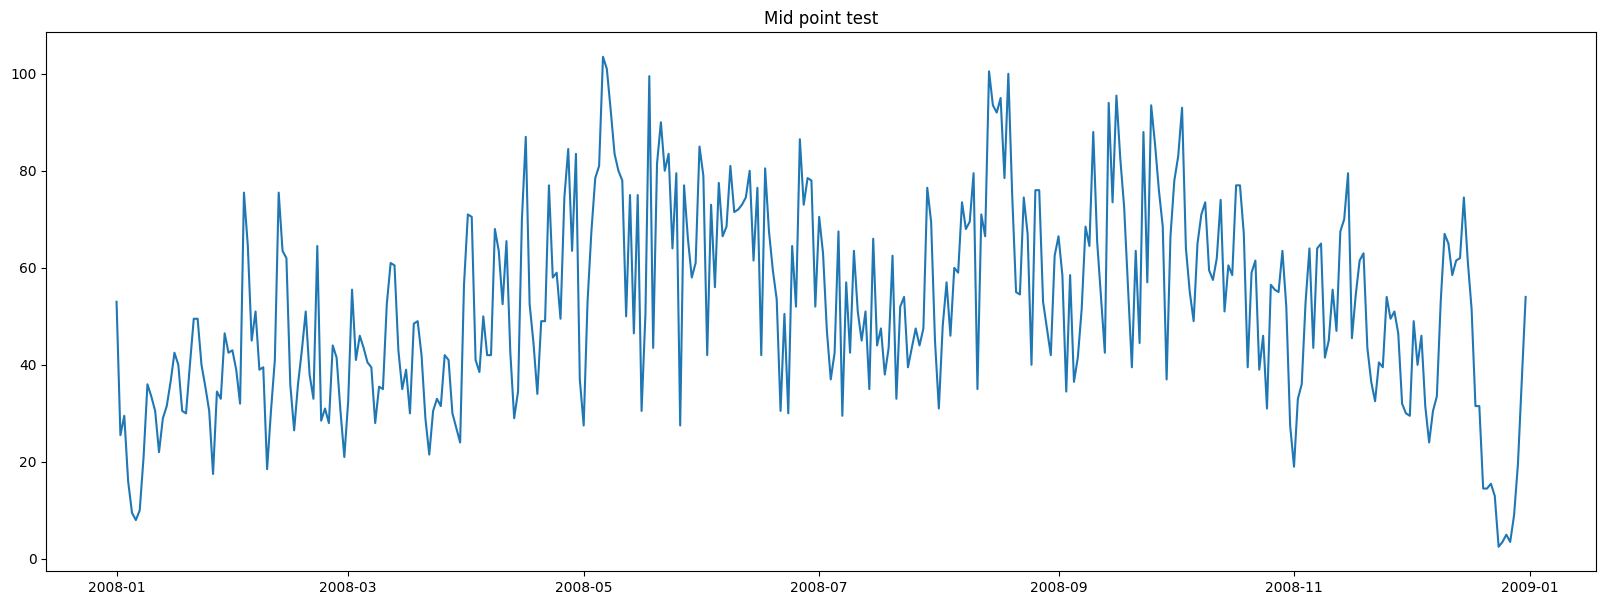

In [34]:
test_list =  test["room_cnt"].tolist()
train_list = train["room_cnt"].tolist()
mid_point_test = list()
date_list = test.index.tolist()
for i in range(len(test)):
    mid_point_test.append((test_list[i] + train_list[i]) / 2)
plt.figure(figsize=(20, 7))
plt.plot(date_list,mid_point_test)
plt.title("Mid point test")

Text(0.5, 1.0, 'test')

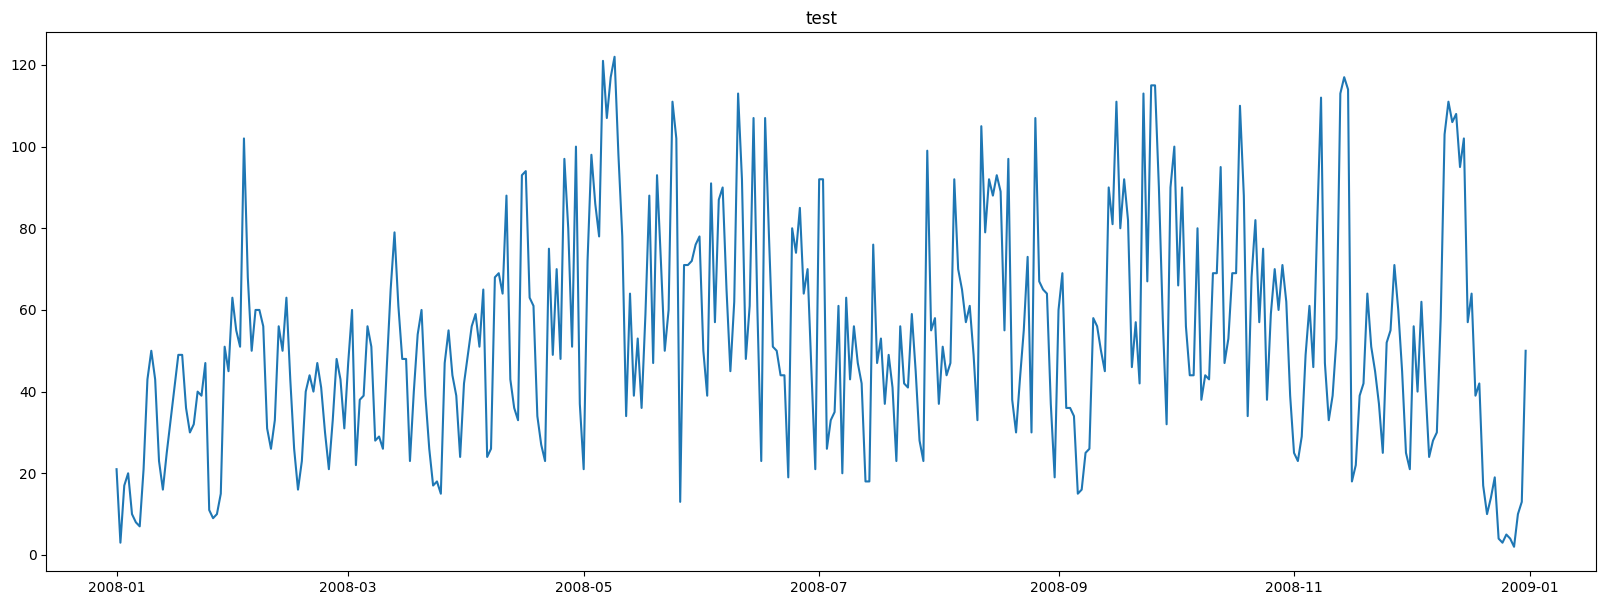

In [35]:
plt.figure(figsize=(20, 7))
plt.plot(test.index,test["room_cnt"])
plt.title("test")

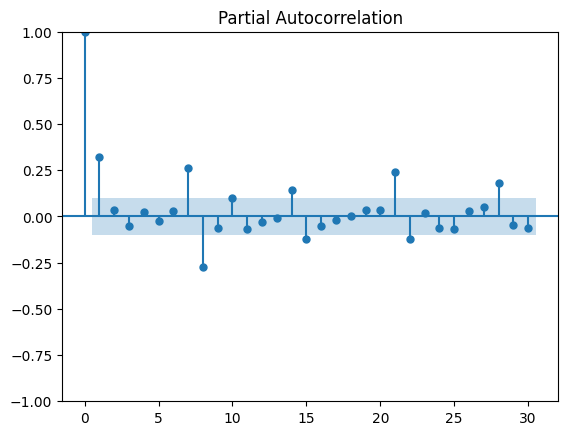

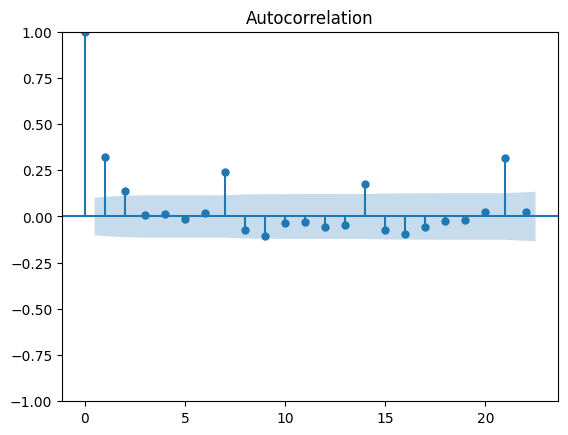

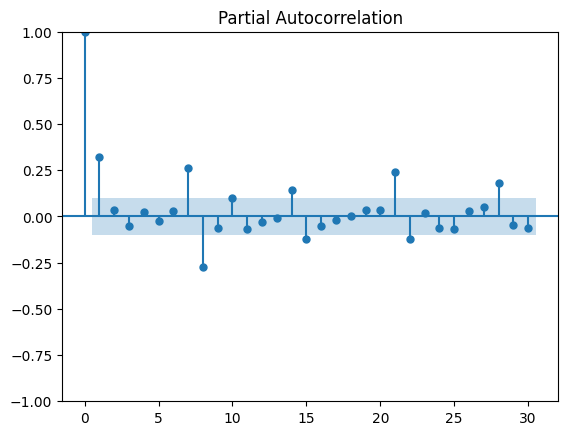

In [36]:
plot_acf(seasonal_difference_df["room_cnt"], lags = 22)
plot_pacf(seasonal_difference_df["room_cnt"], lags = 30)

In [37]:
model = auto_arima(seasonal_difference_df["room_cnt"], seasonal = True, trace = True, approx = False, m = 7)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=606.491, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=734.401, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=656.510, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=678.135, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=734.783, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=667.873, Time=0.29 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=656.264, Time=0.20 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=608.421, Time=2.02 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=608.372, Time=2.19 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=689.996, Time=0.45 sec
 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=664.562, Time=1.01 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=645.948, Time=1.06 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=609.470, Time=2.81 sec
 ARIMA(1,0,2)(1,0,1)[7] intercept   : AIC=605.760, Time=0.76 sec
 ARIMA(1,0,2)(0,0,1)[7] intercept   : AIC=666.3

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  366
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 7)   Log Likelihood                -296.024
Date:                             Sat, 27 Apr 2024   AIC                            602.048
Time:                                     17:13:41   BIC                            621.562
Sample:                                          0   HQIC                           609.802
                                             - 366                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4242      0.048      8.828      0.000       0.330       0.518
ma.L2          0.2389      0.050      4.775      0.000       0.141       0.337
ar.S.L7        0.9482      0.028     34.379      0.000       0.894       1.002
ma.S.L7       -0.7815      0.057    -13.721      0.000      -0.893      -0.670
sigma2         0.2920      0.019     15.535      0.000       0.255       0.329
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 8.50
Prob(Q):                              1.00   Prob(JB):                         0.01
Heteroskedasticity (H):               1.06   Skew:                             0.08
Prob(H) (two-sided):                  0.76   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
mod = ARIMA(seasonal_difference_df["room_cnt"], order = (0,0,2), seasonal_order = (1,0,1,7))
mod = mod.fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                          room_cnt   No. Observations:                  366
Model:             ARIMA(0, 0, 2)x(1, 0, [1], 7)   Log Likelihood                -295.940
Date:                           Sat, 27 Apr 2024   AIC                            603.880
Time:                                   17:13:43   BIC                            627.296
Sample:                                        0   HQIC                           613.185
                                           - 366                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0647      0.161     -0.402      0.688      -0.380       0.251
ma.L1          0.4237      0.048      8.780      0.000       0.329       0.518
ma.L2          0.2383      0.052      4.625      0.000       0.137       0.339
ar.S.L7        0.9480      0.028     34.275      0.000       0.894       1.002
ma.S.L7       -0.7821      0.057    -13.717      0.000      -0.894      -0.670
sigma2         0.2918      0.019     15.534      0.000       0.255       0.329
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 8.40
Prob(Q):                              0.99   Prob(JB):                         0.02
Heteroskedasticity (H):               1.05   Skew:                             0.08
Prob(H) (two-sided):                  0.77   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
import joblib 
joblib.dump(mod, 'arima_trained.pkl')

['arima_trained.pkl']

In [40]:
start = len(seasonal_difference_df)
end = len(test) + len(seasonal_difference_df) - 1

pred = mod.predict(start = start, end = end)

original_train = room_occupancy.iloc[369:]
print(len(pred), len(test))
prediction_list = list()
for i, data in enumerate(train["room_count_log"]):
    prediction_list.append(data)
for i, prediction in enumerate(pred):
    prediction_list[i] += prediction
for i in range(len(prediction_list)):
    prediction_list[i] = math.exp(prediction_list[i])
print(prediction_list)
# Now, 'reverted_values' contains the predicted values in their original scale



366 366
[66.12048731840109, 42.13618581003093, 47.306399698068645, 12.462631927771255, 9.509987177804433, 5.4410636726668695, 8.319151241783903, 15.159606739445238, 24.157299526256445, 18.965896547504002, 18.59458989318347, 22.052204640087563, 29.045817227346312, 24.804754337266452, 29.27010377539165, 36.87794921083642, 34.27326648220505, 12.333922503664159, 25.054159432112648, 35.12921736146174, 44.5650089691052, 43.73261875761931, 34.56393613111164, 26.30744622830613, 51.145789256324356, 26.99050998059558, 42.07826973049926, 34.53287244036224, 31.513849936972466, 33.907309389134774, 25.007058544922405, 23.420477293746803, 13.42383444387602, 35.446316244134835, 42.00811865790859, 30.36235546464535, 35.789217172929334, 19.420402104958963, 23.31987729624205, 6.16452695616058, 25.66206451815333, 34.289314261848084, 72.90566615282486, 65.93943818369343, 65.3341966035584, 29.283575970781754, 27.608390740098766, 41.586858566947065, 44.76111306719359, 48.0777413241171, 27.532412859504465, 27

366


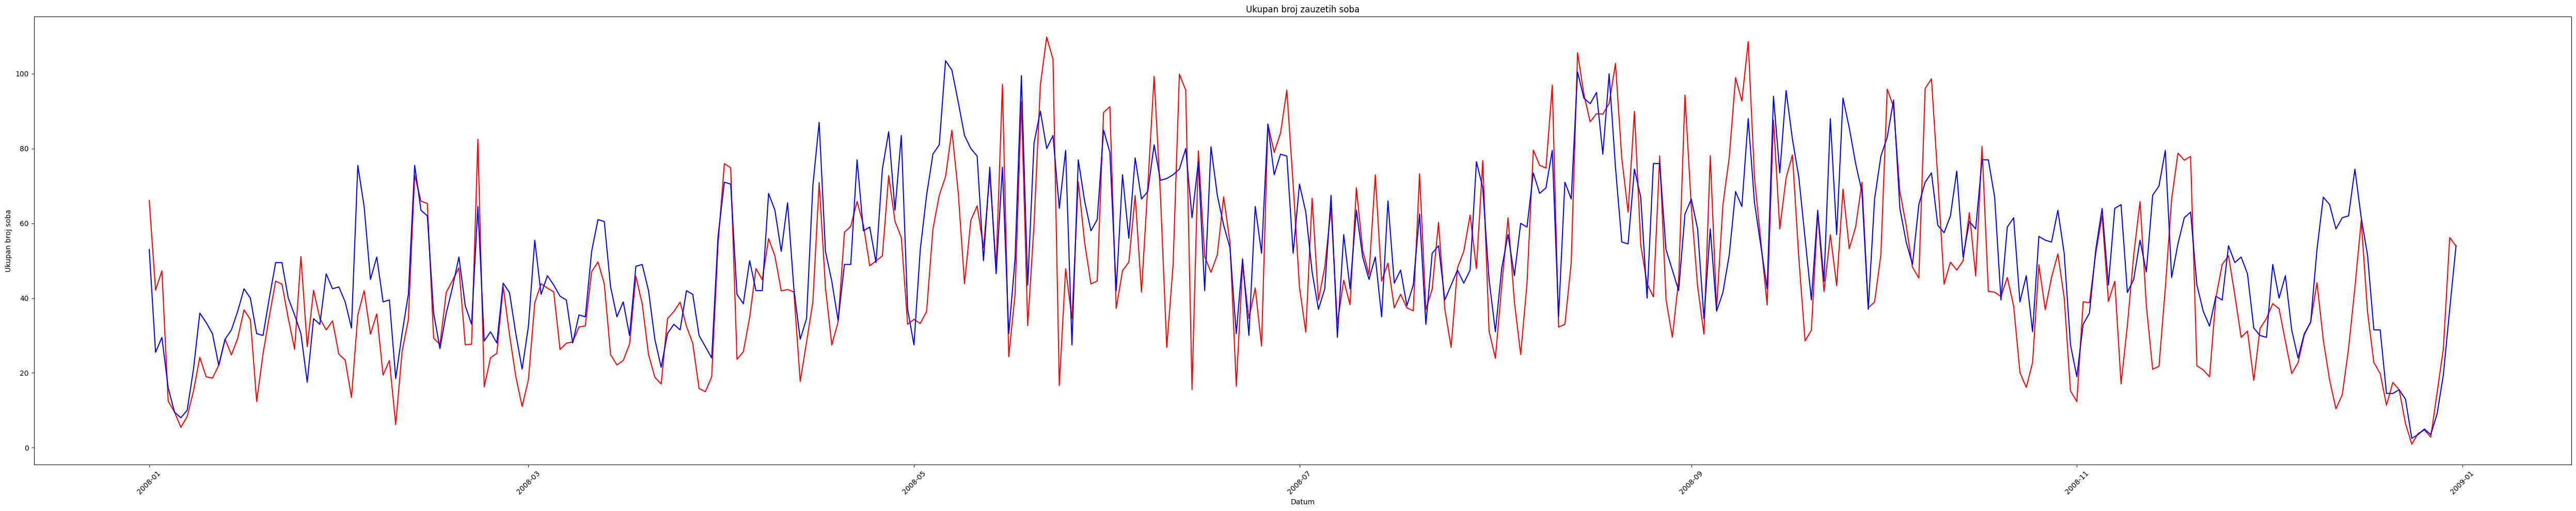

In [41]:
date_list = test.index.tolist()
print(len(prediction_list))
plt.figure(figsize=(50, 10))
plt.plot(date_list, prediction_list,color = "red")
plt.plot(date_list, mid_point_test, color="blue")
plt.title("Ukupan broj zauzetih soba")
plt.xlabel("Datum")
plt.ylabel("Ukupan broj soba")
plt.xticks(rotation = 45) 
plt.tight_layout()  
plt.show()

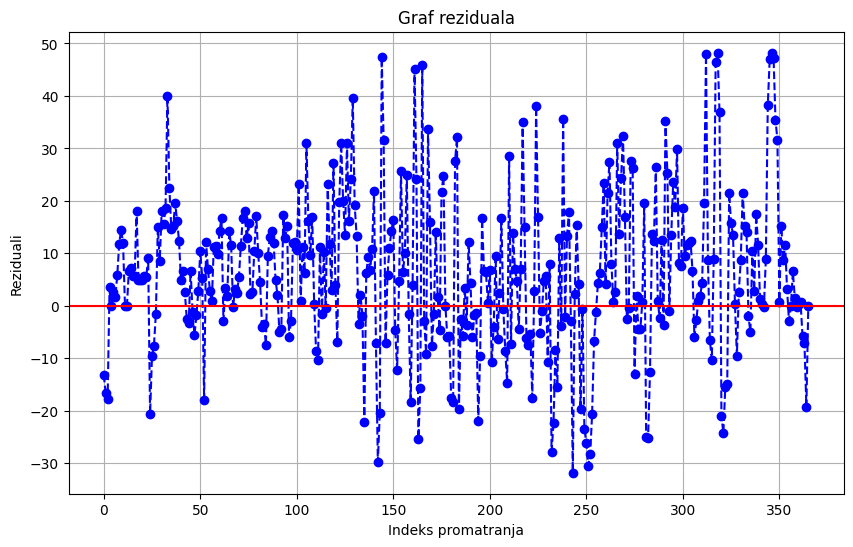

In [19]:
#racunanje residuala
residuals = list()
for i in range(len(mid_point_test)):
    residuals.append(mid_point_test[i]-prediction_list[i])
#residuals = mid_point_test - prediction_list
#residuals_list = residuals.values.tolist()


plt.figure(figsize=(10, 6))  
plt.plot(residuals, marker='o', linestyle='--', color='blue')  
plt.title('Graf reziduala')
plt.xlabel('Indeks promatranja')
plt.ylabel('Reziduali')
plt.axhline(y=0, color='red', linestyle='-')
plt.grid(True)
plt.show()


(array([103.,  78.,  59.,  49.,  26.,  20.,  13.,   7.,   2.,   9.]),
 array([9.98717780e-03, 4.83298637e+00, 9.65598556e+00, 1.44789847e+01,
        1.93019839e+01, 2.41249831e+01, 2.89479823e+01, 3.37709815e+01,
        3.85939807e+01, 4.34169799e+01, 4.82399791e+01]),
 <BarContainer object of 10 artists>)

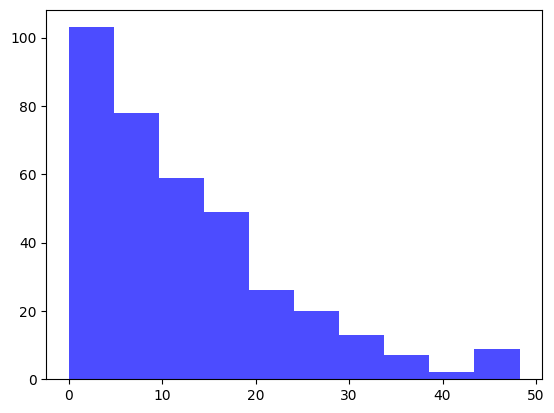

In [20]:
residuals_list = residuals
abs_residuals_list = list(map(abs, residuals_list))
abs_residuals_list = sorted(abs_residuals_list)
alpha_quantile = np.quantile(abs_residuals_list, 1 - 0.20 / 2)
plt.hist(abs_residuals_list, bins=10, color='blue', alpha=0.7) 

## Konformalno predviđanje

In [21]:
residuals_sorted = np.sort(residuals_list)

p_values = [(np.sum(residuals_list >= r) + 1) / (len(residuals_list) + 1) for r in residuals_sorted]
alpha = 0.05

upper_quantile = np.quantile(residuals_sorted, 1 - alpha / 2)
lower_quantile = np.quantile(residuals_sorted, alpha / 2)

def predict_new_point(prediction_point):
    upper_bound = prediction_point + upper_quantile
    lower_bound = prediction_point + lower_quantile
    return lower_bound, upper_bound

lower_list = list()
upper_list = list()
for i in prediction_list:
    lo, hi = predict_new_point(i)
    lower_list.append(lo)
    upper_list.append(hi)
# for i in range(len(lower_list)):
#     print(lower_list[i], upper_list[i])


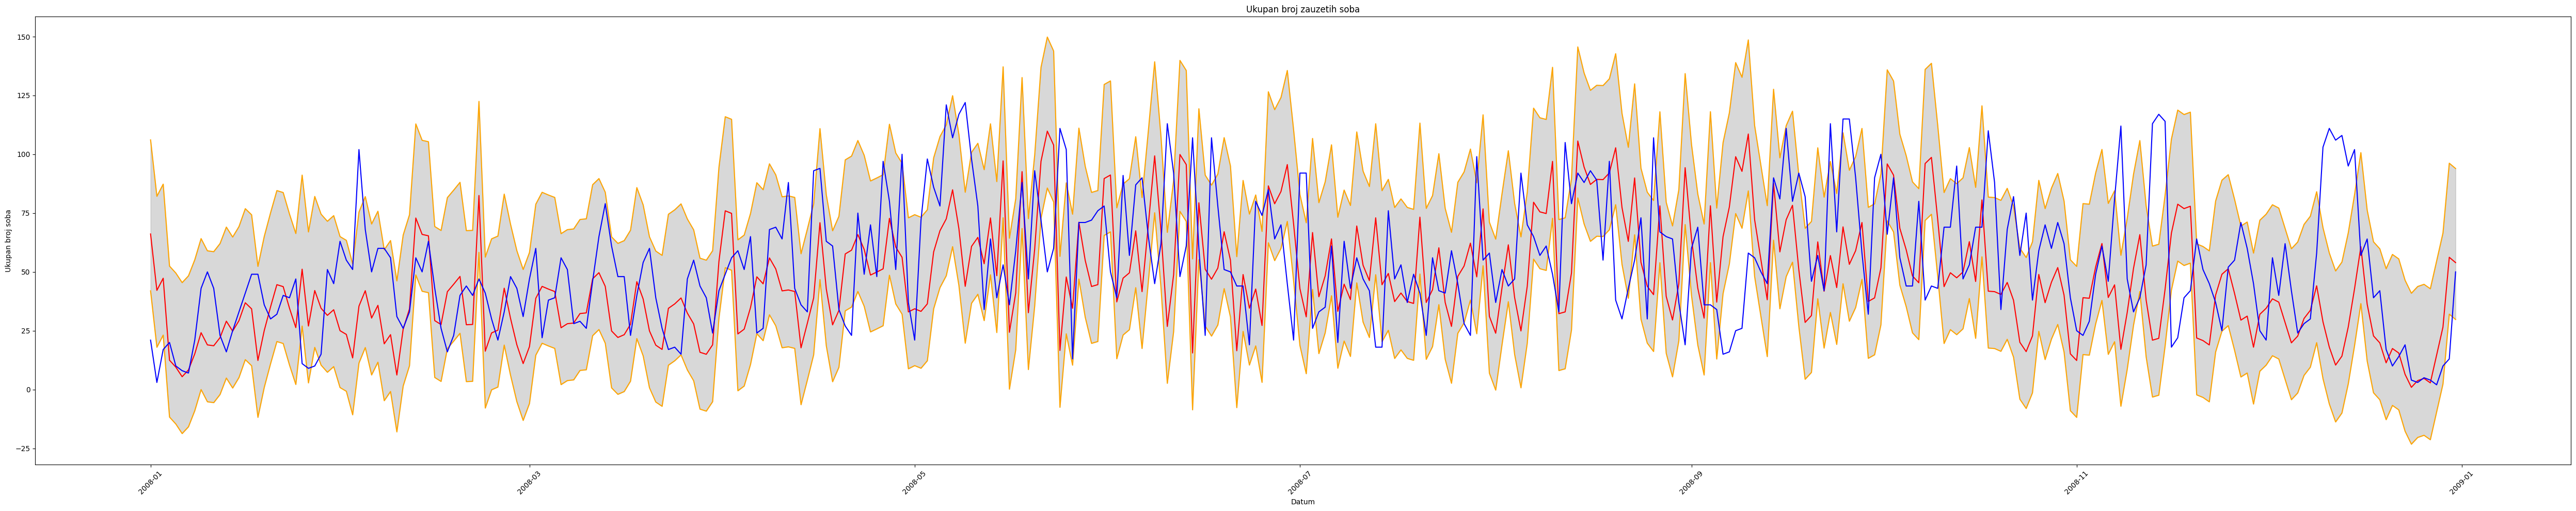

In [42]:
date_list = test.index.tolist()
plt.figure(figsize=(50, 10))
plt.plot(date_list, prediction_list,color = "red")
plt.plot(date_list, upper_list,color = "orange")
plt.plot(date_list, lower_list,color = "orange")
plt.plot(test.index, test["room_cnt"], color="blue")
plt.fill_between(date_list, upper_list, lower_list, color='gray', alpha=0.3)

plt.title("Ukupan broj zauzetih soba")
plt.xlabel("Datum")
plt.ylabel("Ukupan broj soba")
plt.xticks(rotation = 45) 
plt.tight_layout()  
plt.show()



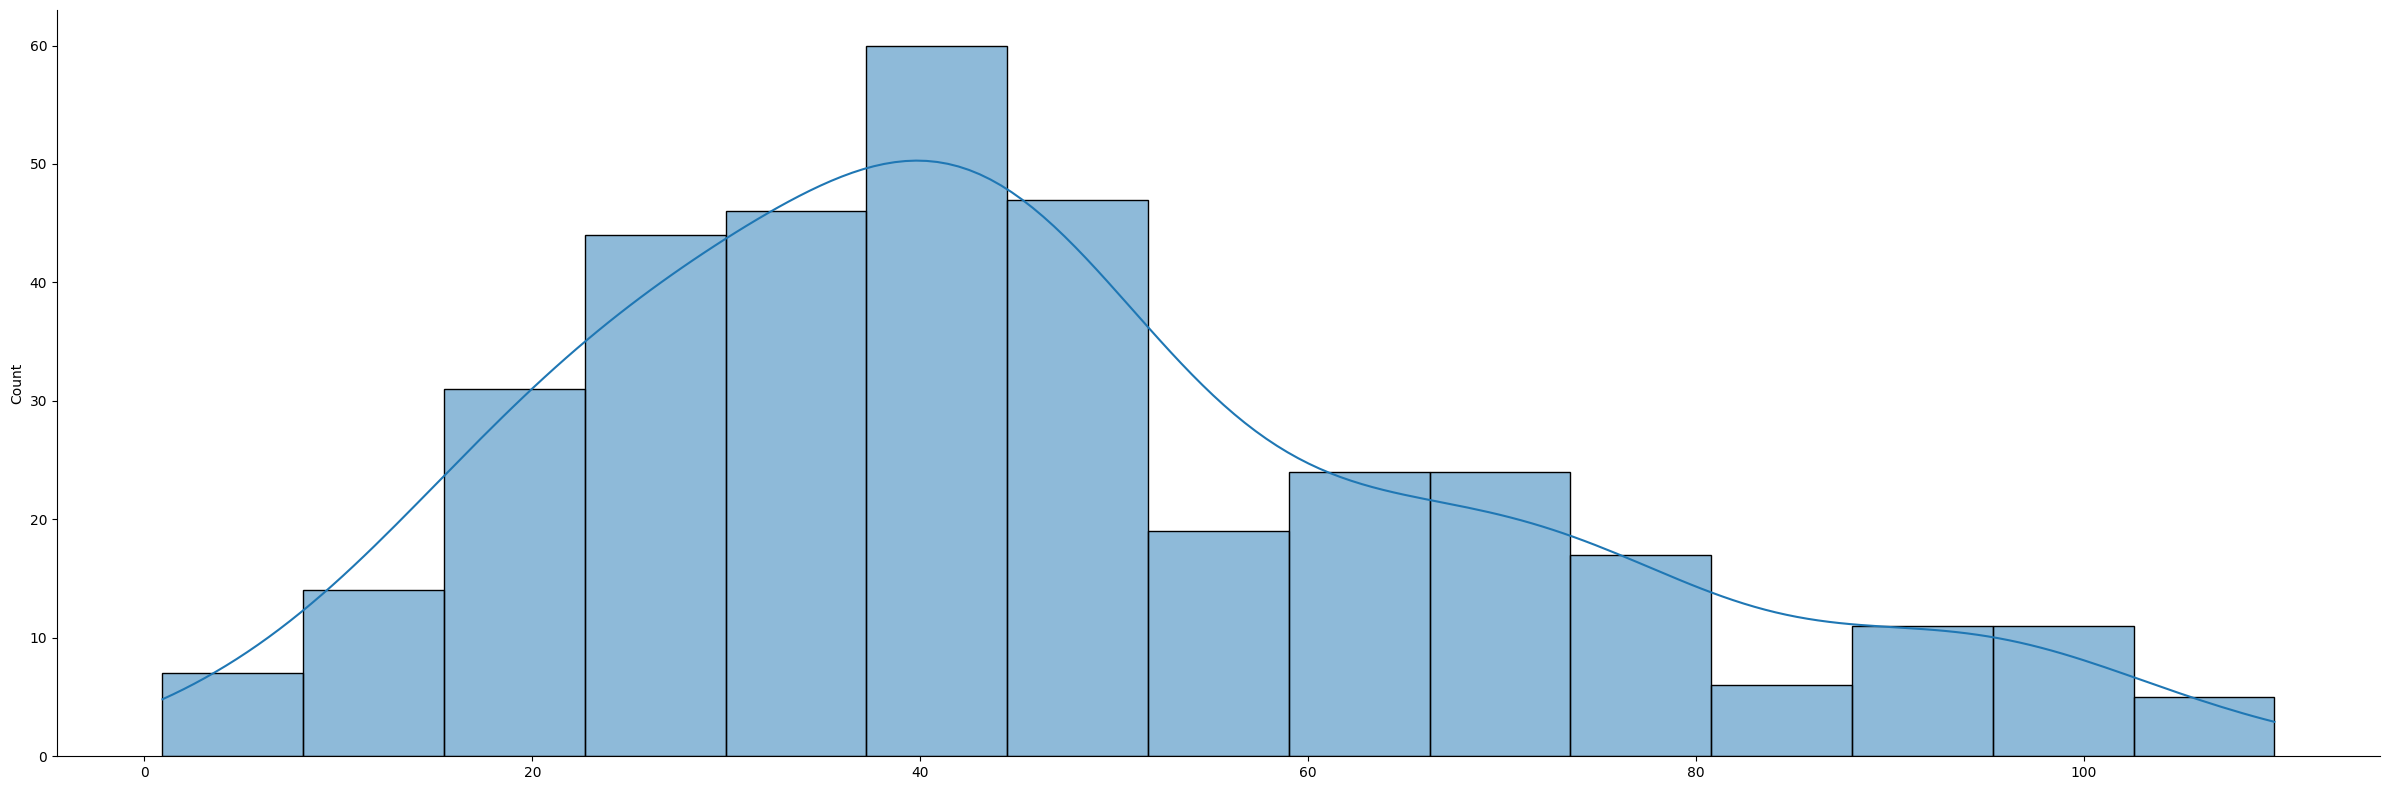

In [27]:
sns.displot(prediction_list,kde = True,height=8, aspect=3, bins = 15)

In [28]:
normalized_prediction, lambda_value = boxcox(prediction_list)
print(normalized_prediction)

[15.61274692 11.88270402 12.75719049  5.31657483  4.35202842  2.74998158
  3.92375041  6.10740587  8.35548196  7.11877884  7.02457991  7.87064968
  9.41032926  8.50058706  9.45664817 10.94012261 10.44992636  5.27692308
  8.55600932 10.61287824 12.29941604 12.15782799 10.50547388  8.83068901
 13.37794879  8.97781834 11.87263212 10.499548    9.91119286 10.37967699
  8.54556249  8.18811705  5.60684149 10.67277375 11.86042382  9.6798816
 10.73726159  7.23291868  8.1650764   3.06801135  8.69002567 10.45299885
 16.54637078 15.58723577 15.50171408  9.45942511  9.10941434 11.78691099
 12.33259249 12.88374135  9.0933074   9.11929087 17.79745563  6.41816883
  8.33200221  8.59449044 12.04455947  9.65667973  7.13253419  4.86183894
  6.93487742 11.28743671 12.17660008 11.9779697  11.79941921  8.81892545
  9.18455087  9.2477122  10.06360732 10.11991353 12.71543029 13.14164024
 12.17713104  8.51862256  7.88721734  8.16021945  9.13443797 12.51415421
 11.23464063  8.52507225  7.09052992  6.61827331 10.

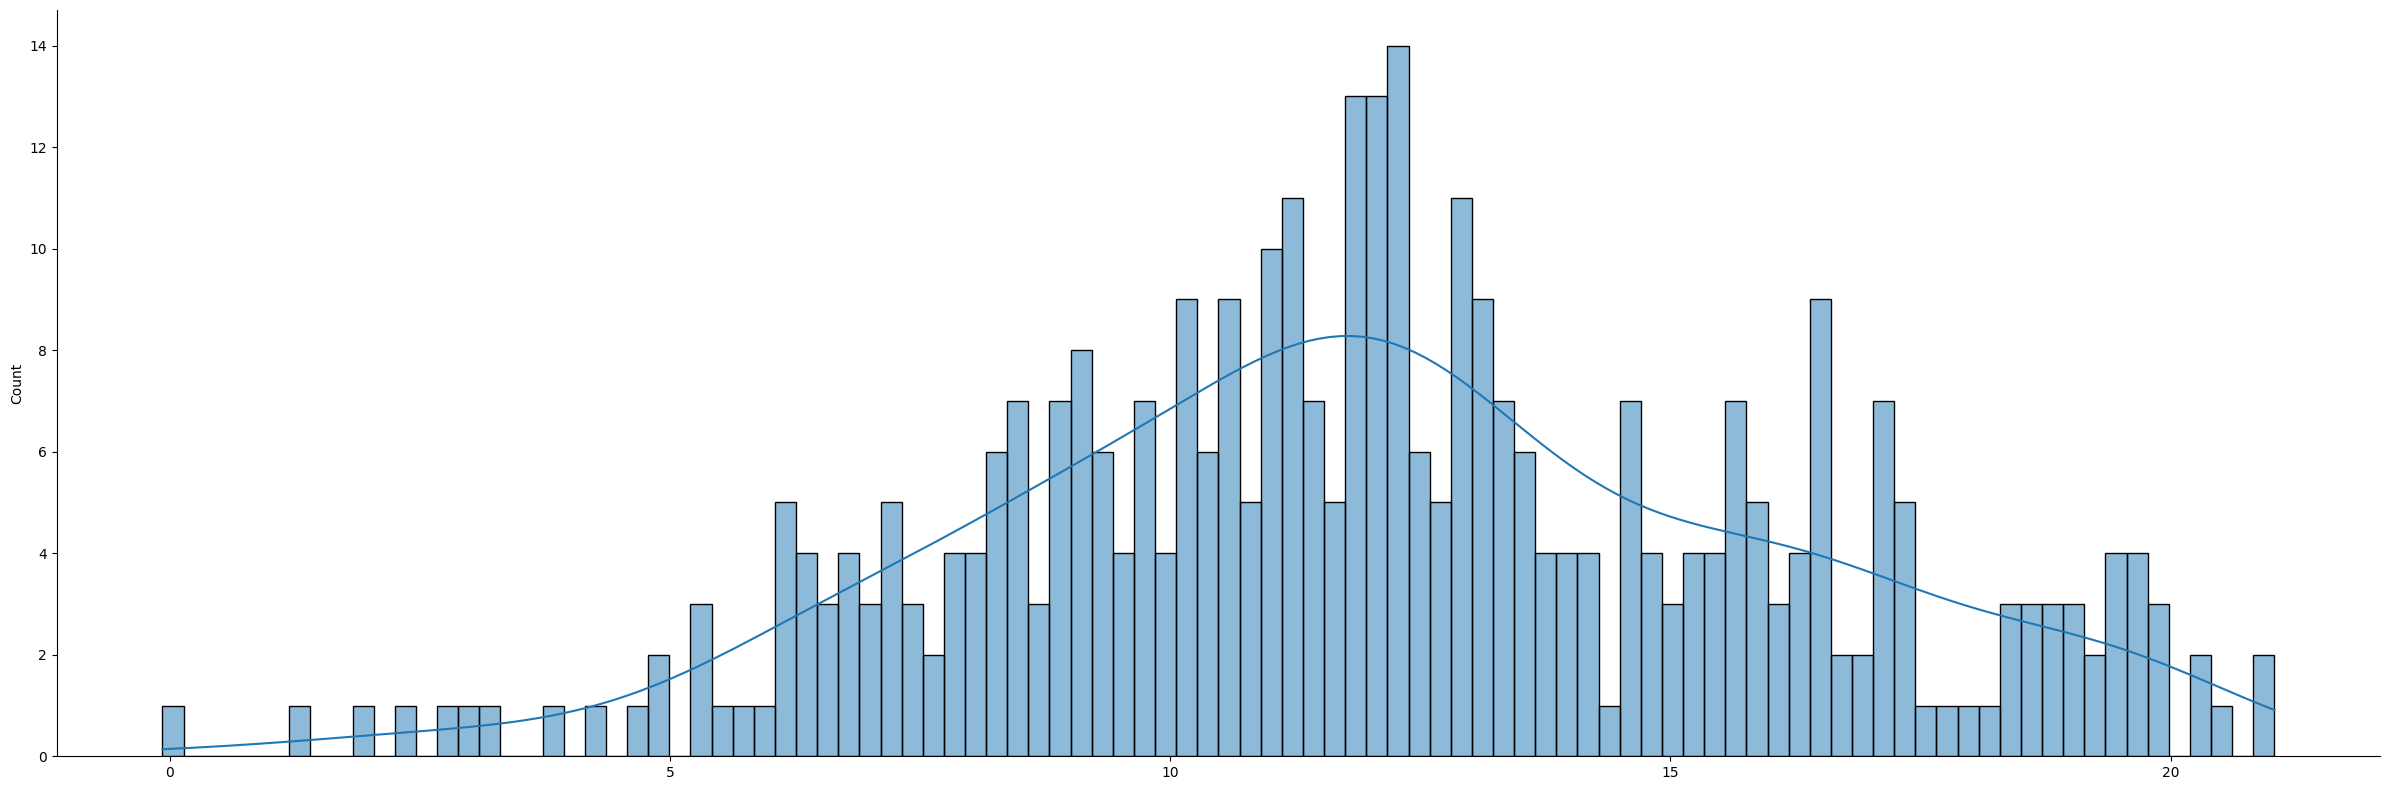

In [29]:
sns.displot(normalized_prediction,kde = True,height=8, aspect=3, bins = 100)

Sada predviđene podatke možemo razmatrati kao slučajnu varijablu s normalnom distribucijom.

In [150]:
mean = 0
for i in prediction_list:
    mean += i
mean /= len(prediction_list)
print(mean)
variance = statistics.variance(prediction_list)
print(math.sqrt(variance))

46.17647184347949
23.19729534287628


Nastavak analize nam trenutno nije potreban, ali smo dobro postavili problem za nastavak i neka delikatnija i preciznija predviđanja.